In [ ]:
import os
import glob
import numpy as np
import itertools
import random
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

from skimage import feature
from PIL import Image, ImageOps
import pywt
import matplotlib.pyplot as plt

from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


from skimage.restoration import denoise_wavelet
%matplotlib inline

In [60]:
path2train = 'data/train/'
path2test = 'data/test'

In [61]:
img_width = img_height=256

In [62]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [63]:
def preProcessing(img):
    
    #img = resizeImage(img)
    img = RandomCropImage(img)
    img = RGB2Gray(img)
    #img = median_filter(img)
    #img = localBinaryPatterns(img)
    #img = addDelta(img)
    img = vectorizeImage(img)
    return img

In [64]:
def RandomCropImage(img, img_width=128, img_height=128):
    
    width = img.size[0]
    height = img.size[1]

    idx_width = random.randint(0, width - img_width)
    idx_height = random.randint(0, height - img_height)

    return img.crop((idx_width, idx_height, idx_width+img_width, idx_height + img_height))

In [65]:
def addDelta(img):
    return img + 1e-3

In [66]:
def vectorizeImage(img, img_width=128, img_height=128):
    return img.reshape(-1,img_width * img_height)

In [67]:
def median_filter(img, factor=2):
    
    filtered = ndimage.median_filter(img, factor)
    img = img - filtered
    return img   

In [68]:
def resizeImage(img, img_width=128, img_height=128):
    img = img.resize((img_width, img_height))
    return np.array(img)

In [69]:
def localBinaryPatterns(img, numPoints=24, radius=2):
    
    lbp = feature.local_binary_pattern(img, numPoints,
                    radius, method="uniform")
    return lbp

In [70]:
def RGB2Gray(img):
    img = np.array(img)
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [71]:
def extractImage(path):

    with Image.open(path) as img:
        img = preProcessing(img)
    target = path.split('/')[-2]
#    return {'img': img, 'target': target}
    return img, target

In [72]:
def extractImagesParallel(path, threads=2):
    pool = ThreadPool(threads)
    #imgs, targets = zip(*pool.map(extractImage, path))
    result = pool.map(extractImage, path)
    pool.close()
    pool.join()
    return result

In [73]:
def get_data(path, format_file = '*.jpg', is_train = True):
    results = []

    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':

            print('Reading files from dir: {}'.format(subdir))

            path_folder = os.path.join(subdir, format_file)
            filesPath = glob.glob(path_folder) 

            res  = extractImagesParallel(filesPath, cpu_count)
            results.append(res)
    
    flattened_list = [y for x in results for y in x]
    X, y = map(list, zip(*flattened_list))
    X = np.squeeze(np.array(X), axis=1)
    y = np.array(y)
    return X, y

In [74]:
print('Reading training data...\n')
X, y = get_data(path2train)
print('Reading testing data...')
X_test, _ = get_data(path2test, format_file='*.tif', is_train=False)

Reading training data...

Reading files from dir: data/train/iPhone-4s
Reading files from dir: data/train/Motorola-Droid-Maxx
Reading files from dir: data/train/HTC-1-M7
Reading files from dir: data/train/Samsung-Galaxy-S4
Reading files from dir: data/train/Motorola-X
Reading files from dir: data/train/Motorola-Nexus-6
Reading files from dir: data/train/LG-Nexus-5x
Reading files from dir: data/train/Samsung-Galaxy-Note3
Reading files from dir: data/train/iPhone-6
Reading files from dir: data/train/Sony-NEX-7
Reading testing data...
Reading files from dir: data/test


In [75]:
def showCamaraPhotos(X, y=[], is_train =True, img_width=128, img_height=128):

    idx = random.randint(0,len(X))
    if is_train:
        plt.title(y[idx])
    img = X[idx].reshape(img_width, img_height)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

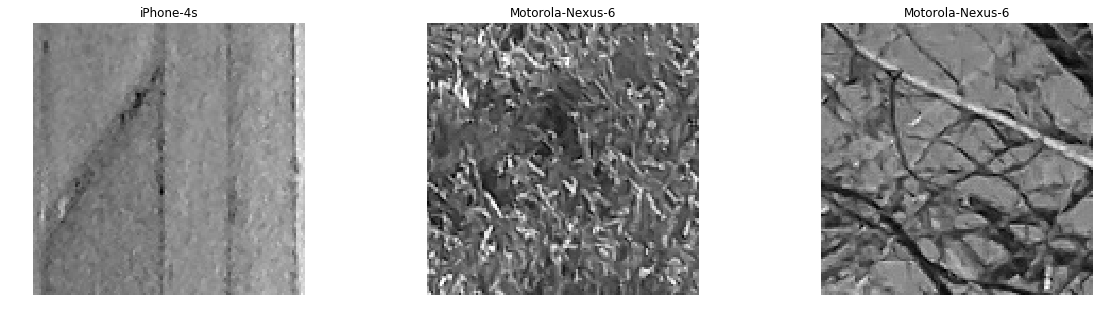

In [76]:
plt.figure(figsize=(20,5))
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    showCamaraPhotos(X, y)

In [77]:
test_size = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

In [78]:
print('Shape of the training data X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('Shape of the valid data X: {}, y: {}'.format(X_valid.shape, y_valid.shape))

Shape of the training data X: (2200, 16384), y: (2200,)
Shape of the valid data X: (550, 16384), y: (550,)


### Normalization

In [54]:
def MinMaxNormalization(X, y=[], x_factor={}, y_factor = {}, transformation = False):

    if not(transformation):
        x_factor = {'min': X.min(axis=0), 'max': X.max(axis=0)}
        if len(y)  != 0:
            y_factor = {'min': y.min(axis=0), 'max': y.max(axis=0)}

    X = (X - x_factor['min'])/(x_factor['max']-x_factor['min'])
    if len(y)  != 0:
        y = (y - y_factor['min']) / (y_factor['max'] - y_factor['min'])
    
    return X, y, x_factor, y_factor

In [55]:
def zScoreNormalization(X, y=[], x_factor={}, y_factor = {}, transformation = False):
    
    if not(transformation):
        x_factor = {'mean': X.mean(axis=0), 'std': X.std(axis=0)}
        if len(y)  != 0:
            y_factor = {'mean': y.mean(axis=0), 'std': y.std(axis=0)}

    X=(X-x_factor['mean'])/x_factor['std']
    
    if len(y)  != 0:
        y=(y-y_factor['mean'])/y_factor['std']
    
    return X, y, x_factor, y_factor

In [56]:
normalization_type = 'zScore'

In [57]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    
    X_train, _, x_factor, y_factor  = MinMaxNormalization(X_train)
    X_valid, _, _, _  = MinMaxNormalization(X_valid, x_factor=x_factor, y_factor=y_factor, transformation=True)
    #X_test, _, _, _  = MinMaxNormalization(X_test, x_factor=x_factor, y_factor=y_factor, transformation=True)

elif normalization_type == 'zScore':
        
    X_train, _, x_factor, y_factor  = zScoreNormalization(X_train)
    X_valid, _, _, _  = zScoreNormalization(X_valid, x_factor=x_factor, y_factor=y_factor, transformation=True)
    #X_test, _, _, _  = zScoreNormalization(X_test, x_factor=x_factor, y_factor=y_factor, transformation=True)

Normalization type: zScore


# Model

### Logistic Regression

In [ ]:
lr_model = linear_model.LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_valid)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_model.score(X_valid, y_valid)))

### Neural Network

In [ ]:
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)
y_pred_mlp = lr_model.predict(X_valid)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(mlp_model.score(X_valid, y_valid)))

In [ ]:
cm_lr = confusion_matrix(y_valid, y_pred_lr)
cm_mlp = confusion_matrix(y_valid, y_pred_mlp)

In [ ]:
def plot_cm(cm, title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)

In [ ]:
plt.figure(figsize=(8, 6))
plt,subplot(1,2,1)
plot_cm(cm_lr)

plt,subplot(1,2,2)
plot_cm(cm_mlp)

In [24]:
print(np.array(X).shape)
img_wav_filtered = denoise_wavelet(X, multichannel=True, convert2ycbcr=True,  mode='soft')

(2750, 16384)


/home/renatolr/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (2750, 16384)

### Wavelet

In [ ]:
'''
import glob, os
folder = 'data/train/Sony-NEX-7'
for filename in glob.iglob(os.path.join(folder, '*.JPG')):
    os.rename(filename, filename[:-4] + '.jpg')
'''